In [1]:
local = True

In [2]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive')#, force_remount=True)

In [3]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

# Convolutional Neural Networks


In [4]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [5]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToPILImage

from CustomDataLoaderNPY import CustomDatasetNPY
from torch.utils.data import DataLoader
from model_architectures import CustomCNN, CustomCNN_eeg, TransNet_Resnet18_unfrozen, TransNet_Efficientnetb0_unfrozen

import os

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    print("GPU count", torch.cuda.device_count())

CUDA is not available.  Training on CPU ...


---
## Load the Data

In [7]:
# Type of input data
data_type = "eeg_spec"  #"spec" # "eeg_raw" #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = 0 #cpu.cpu_count() #- 1
# how many samples per batch to load
batch_size = 64
# label smoothing
label_smoothing = 0.01

In [8]:
# Load (train or test) data from csv file
if local:
    path = f"C:/Users/Amy/Desktop/Green_Git/eegClassification/data/data_prep_all_{data_type}/"
    path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
else:
    path = f"./data_prep_all_{data_type}/"
    path_df = "./data/"


In [9]:
if data_type == "spec":
    input_shape = (3,400,299)
elif data_type == "eeg_spec":
    input_shape = (3, 140, 129)#(20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [10]:
data_path = path+'train/'
data_files = os.listdir(data_path)
data_files = [f.split('.')[0].split('_')[1] for f in data_files if f.startswith('images')]
N_items = len(data_files)

print("Number of items", N_items)



Number of items 1736


In [11]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)

In [12]:
get_batch_transform = lambda x, y: (
    x[0, :],
    y[0, :],
)

In [13]:
# split data_files into training, validation, and test data (0.7, 0.2, 0.1)
np.random.seed(0)
np.random.shuffle(data_files)
train_files = data_files[:int(0.7*N_items)]
val_files = data_files[int(0.7*N_items):int(N_items)]#data_files[int(0.7*N_items):int(0.9*N_items)]
# test_files = data_files[int(0.9*N_items):]


In [14]:
train_files[:10], val_files[:10]#, test_files[:10]

(['883', '578', '794', '1142', '1466', '467', '244', '286', '107', '1389'],
 ['1445', '163', '1335', '313', '524', '650', '1361', '1375', '831', '477'])

In [15]:
# # check that all files in train_files exist
# for files in [train_files, val_files, test_files]:
#   for f in files:
#       if not os.path.isfile(data_path+ "images_" +f+'.npy'):
#           print(f)
#       if not os.path.isfile(data_path+ "votes_" +f+'.npy'):
#           print(f)

In [16]:
train_data = CustomDatasetNPY(data_path, train_files)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=num_workers)

valid_data = CustomDatasetNPY(data_path, val_files)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=num_workers)

# test_data = CustomDatasetNPY(data_path, test_files)
# test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [17]:
%%time
# obtain one batch of training images
dataiter = iter(train_loader)
data, class_votes = next(dataiter)
data, class_votes = get_batch_transform(data, class_votes)

class_votes.shape, data.shape

CPU times: total: 93.8 ms
Wall time: 10.6 ms


(torch.Size([64, 6]), torch.Size([64, 3, 140, 129]))

In [18]:
data.shape

torch.Size([64, 3, 140, 129])

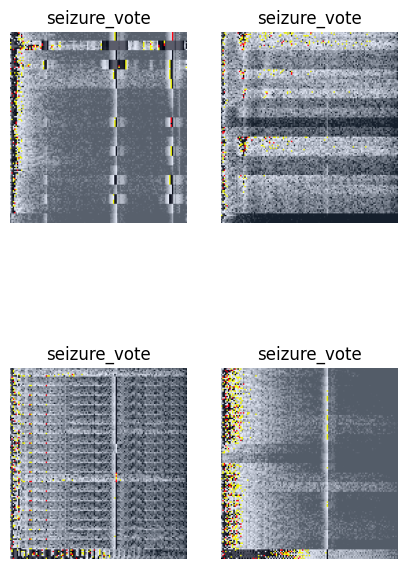

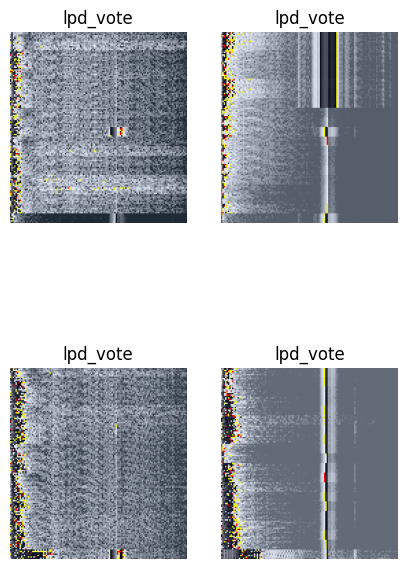

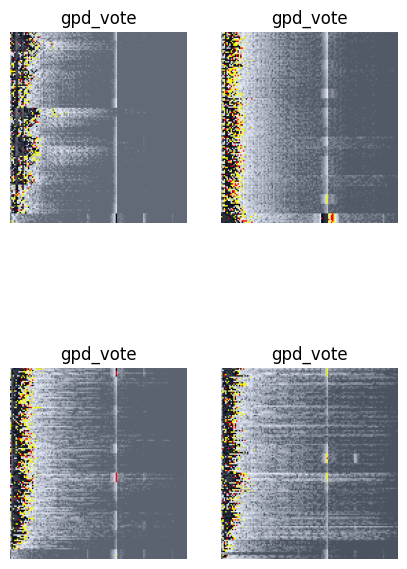

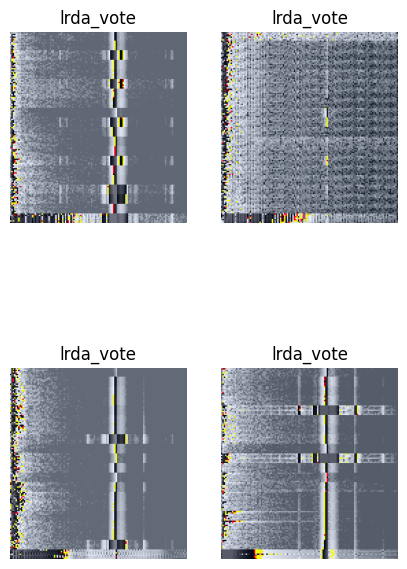

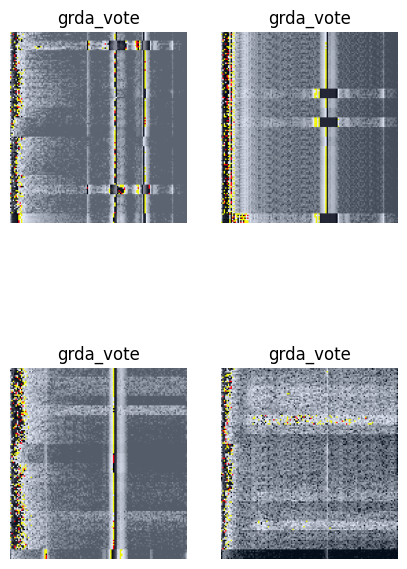

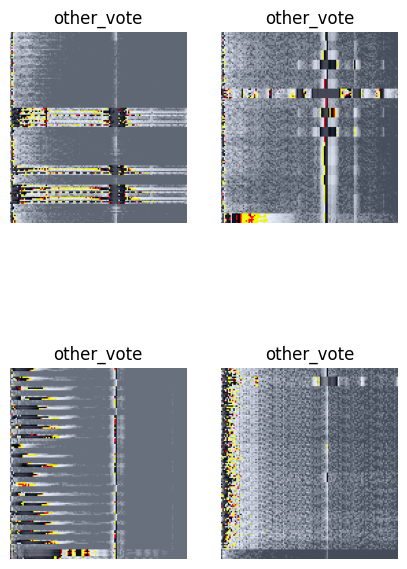

In [19]:
# sort the labels in accending order
label = np.argmax(class_votes, axis=1)
label, indices = torch.sort(label)
data = data[indices, :]
class_votes = class_votes[indices, :]

# image show data
for i in range(N_classes):
    size = 4
    # indices of items in the class
    idxs = np.where(label == i)[0]
    # image show data
    fig, ax = plt.subplots(2, size//2, figsize = (5,8))
    # title
    ax[0,0].set_title(classes[i])
    for j in range(size//2):
        for i in range(2):
            if i*2+j > len(idxs)-1:
              ax[i,j].axis("off")
            else:
              idx = idxs[i*2+j]
              img = ToPILImage()(data[idx, :])
              ax[i,j].imshow(img)
              ax[i,j].set_title(classes[label[idx]])
              ax[i,j].axis("off")

    plt.show()





## Define the Network Architecture


In [20]:
model_name = "CustomCNN_eeg" #"CustomCNN" # "TransNet_Efficientnetb0" #"TransNet_Resnet18" #


if model_name == "CustomCNN":
  model = CustomCNN(input_shape=input_shape, N_classes = N_classes)
elif model_name == "CustomCNN_eeg":
  model = CustomCNN_eeg(input_shape=input_shape, N_classes = N_classes)
elif model_name == "TransNet_Resnet18":
  model = TransNet_Resnet18_unfrozen(input_shape=input_shape, N_classes = N_classes)
elif model_name == "TransNet_Efficientnetb0":
  model = TransNet_Efficientnetb0_unfrozen(input_shape=input_shape, N_classes = N_classes)
else:
  raise ValueError("Model not found")

# index = 0
# path_model_old = f"./model_{model_name}_{index}.pt"
# model.load_state_dict(torch.load(path_model_old))

In [21]:
model

CustomCNN_eeg(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [22]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [23]:
num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters in the model', num_parameters)

# number of trainable parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in the model', num_parameters)

Number of parameters in the model 1092898
Number of trainable parameters in the model 1092898


### Specify [Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) and [Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)


## Learning rate scheduler

In [24]:
lr_start, lr_max, lr_min = 2e-4, 3e-5 * batch_size, 1e-5
lr_ramp_ep, lr_sus_ep, lr_decay = 4, 0, 0.75

def lrfn(epoch, epochs, mode='cos'):  # Learning rate update function
    if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
    elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
    elif mode == 'cos':
        decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
        phase = np.pi * decay_epoch_index / decay_total_epochs
        lr = (lr_max - lr_min) * 0.5 * (1 + np.cos(phase)) + lr_min
    return lr

In [25]:
# check if "f"./model_{model_name}_*" exists and add 1 to the index
index = 0
while os.path.exists(f"./model_{model_name}_{index}.pt"):
    index += 1


In [26]:
n_epochs = 30
configs = {'n_epochs': n_epochs,
           'path_model':f"./model_{model_name}_{index}.pt",
           'learning_rate': [lrfn(epoch, n_epochs) for epoch in np.arange(n_epochs)],
           'label_smoothing': label_smoothing,
}

configs

{'n_epochs': 30,
 'path_model': './model_CustomCNN_eeg_2.pt',
 'learning_rate': [0.0002,
  0.00063,
  0.00106,
  0.00149,
  0.00192,
  0.0019144017490824135,
  0.0018976726307031327,
  0.0018700087784795764,
  0.0018317345257857641,
  0.0017832986032400478,
  0.00172526887774889,
  0.00165832569478659,
  0.0015832539019666454,
  0.0015009336474210754,
  0.0014123300608682996,
  0.0013184819383496185,
  0.0012204895632954057,
  0.0011195018067078903,
  0.0010167026576990738,
  0.0009132973423009265,
  0.0008104981932921097,
  0.0007095104367045941,
  0.000611518061650382,
  0.0005176699391317006,
  0.00042906635257892496,
  0.0003467460980333547,
  0.0002716743052134104,
  0.00020473112225111043,
  0.00014670139675995223,
  9.826547421423595e-05],
 'label_smoothing': 0.01}

In [27]:
model_info = {}
model_info['configs'] = configs

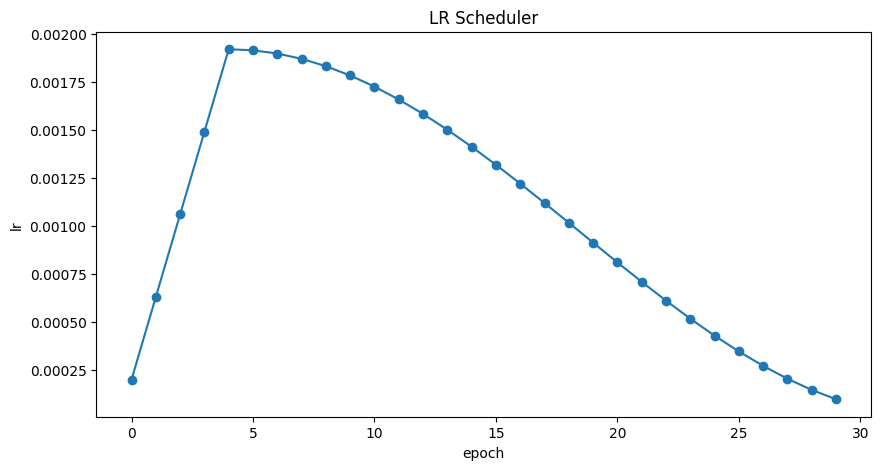

In [28]:
# Plot lr curve if plot is True
plt.figure(figsize=(10, 5))
plt.plot(np.arange(configs['n_epochs']), configs['learning_rate'], marker='o')
plt.xlabel('epoch'); plt.ylabel('lr')
plt.title('LR Scheduler')
plt.show()

In [29]:
def train(model, train_loader, valid_loader, path_model, n_epochs, learning_rate, label_smoothing, test = False, valid_loss_min = np.Inf):
    criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)
    optimizer = optim.Adam(model.parameters())

    track_loss = []
    track_loss_val = []

    max_samples = 5

    print('Epoch: \tTraining Loss:  \tValidation Loss:')
    for epoch in range(1, n_epochs+1):

        for g in optimizer.param_groups:
          g['lr'] = learning_rate[epoch-1]#lrfn(epoch, n_epochs)
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        count = 0

        if not local:
          drive.flush_and_unmount()
          drive.mount('/content/drive')

        for data, votes in tqdm(train_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # offset vote by adding label smoothing as offset
            votes = votes * (1 - label_smoothing) + label_smoothing / N_classes

            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            if torch.isnan(output).sum() > 0:
                print("Nan in output")
            else:

                # loss
                loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))

                # update training loss
                train_loss += loss.item()#*data.size(0)

                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()

                optimizer.step()
                
                count +=1

            


        torch.cuda.empty_cache()
        ######################
        # validate the model #
        ######################
        model.eval()
        count = 0
        for data, votes in tqdm(valid_loader):
            if test and count >= max_samples:
                break

            data, votes = get_batch_transform(data, votes)
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, votes = data.cuda(), votes.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            if torch.isnan(output).sum() > 0:
                print("Nan in output")
            else:
                # calculate the batch loss
                loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
                # update average validation loss
                valid_loss += loss.item()#*data.size(0)

                count +=1


        torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(train_loader)#/batch_size
        valid_loss = valid_loss/len(valid_loader)#/batch_size

        track_loss.append(train_loss)
        track_loss_val.append(valid_loss)

        # print training/validation statistics
        print('{}; \t{:.6f}; \t{:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), path_model)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss

        gc.collect()

    return track_loss, track_loss_val

In [30]:
model_info['track_loss'] = [] 
model_info['track_loss_val'] = []

In [31]:
valid_loss_min = np.min(model_info['track_loss_val']) if len(model_info['track_loss_val']) > 0 else np.Inf
valid_loss_min

inf

In [32]:
track_loss, track_loss_val = train(model, train_loader, valid_loader, valid_loss_min=valid_loss_min, **configs)

Epoch: 	Training Loss:  	Validation Loss:


 20%|█▉        | 237/1215 [00:22<01:25, 11.38it/s]

Nan in output


 31%|███       | 371/1215 [00:34<01:13, 11.48it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.04it/s]

Nan in output


 85%|████████▌ | 444/521 [00:24<00:04, 18.50it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.40it/s]


1; 	0.958063; 	0.951911
Validation loss decreased (inf --> 0.951911).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:29, 10.88it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:18, 10.83it/s]

Nan in output


 35%|███▍      | 181/521 [00:10<00:19, 17.80it/s]

Nan in output


 85%|████████▌ | 443/521 [00:25<00:04, 17.61it/s]

Nan in output


100%|██████████| 521/521 [00:29<00:00, 17.46it/s]


2; 	0.810234; 	0.765893
Validation loss decreased (0.951911 --> 0.765893).  Saving model ...


 19%|█▉        | 236/1215 [00:25<01:32, 10.61it/s]

Nan in output


 30%|███       | 370/1215 [00:40<01:18, 10.82it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.39it/s]

Nan in output


 85%|████████▌ | 444/521 [00:24<00:04, 18.35it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.34it/s]


3; 	0.690908; 	0.622972
Validation loss decreased (0.765893 --> 0.622972).  Saving model ...


 19%|█▉        | 236/1215 [00:25<01:34, 10.41it/s]

Nan in output


 30%|███       | 370/1215 [00:39<01:19, 10.62it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:19, 17.33it/s]

Nan in output


 85%|████████▌ | 444/521 [00:24<00:04, 18.06it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.08it/s]


4; 	0.606458; 	0.538032
Validation loss decreased (0.622972 --> 0.538032).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:31, 10.75it/s]

Nan in output


 30%|███       | 370/1215 [00:38<01:18, 10.78it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.50it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.42it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.44it/s]


5; 	0.555450; 	0.497400
Validation loss decreased (0.538032 --> 0.497400).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:30, 10.80it/s]

Nan in output


 30%|███       | 370/1215 [00:38<01:17, 10.89it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.52it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.54it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.58it/s]


6; 	0.512678; 	0.476698
Validation loss decreased (0.497400 --> 0.476698).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:29, 10.89it/s]

Nan in output


 30%|███       | 370/1215 [00:38<01:18, 10.74it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.81it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.60it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.62it/s]


7; 	0.483602; 	0.440695
Validation loss decreased (0.476698 --> 0.440695).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:30, 10.86it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 11.04it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.56it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.68it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.64it/s]


8; 	0.462083; 	0.417935
Validation loss decreased (0.440695 --> 0.417935).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:29, 10.94it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:18, 10.82it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.73it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 17.36it/s]

Nan in output


100%|██████████| 521/521 [00:28<00:00, 18.58it/s]


9; 	0.445864; 	0.392700
Validation loss decreased (0.417935 --> 0.392700).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:29, 10.94it/s]

Nan in output


 30%|███       | 370/1215 [00:38<01:16, 11.05it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:17, 18.94it/s]

Nan in output


 85%|████████▌ | 445/521 [00:23<00:03, 19.05it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.73it/s]


10; 	0.431694; 	0.396762


 19%|█▉        | 236/1215 [00:24<01:43,  9.46it/s]

Nan in output


 31%|███       | 371/1215 [00:37<01:20, 10.49it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.74it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.63it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.62it/s]


11; 	0.417221; 	0.382831
Validation loss decreased (0.392700 --> 0.382831).  Saving model ...


 19%|█▉        | 236/1215 [00:24<01:29, 10.93it/s]

Nan in output


 30%|███       | 369/1215 [00:37<01:18, 10.74it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.82it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.31it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.79it/s]


12; 	0.408202; 	0.358940
Validation loss decreased (0.382831 --> 0.358940).  Saving model ...


 20%|█▉        | 237/1215 [00:23<01:31, 10.63it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.94it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:17, 19.03it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.69it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.79it/s]


13; 	0.396669; 	0.355658
Validation loss decreased (0.358940 --> 0.355658).  Saving model ...


 20%|█▉        | 237/1215 [00:23<01:33, 10.50it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:18, 10.83it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:17, 18.97it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.93it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.89it/s]


14; 	0.388198; 	0.363648


 19%|█▉        | 236/1215 [00:23<01:31, 10.72it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 11.03it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.64it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.82it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.69it/s]


15; 	0.379508; 	0.349547
Validation loss decreased (0.355658 --> 0.349547).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:28, 11.02it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 11.04it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.74it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.90it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.78it/s]


16; 	0.372652; 	0.330084
Validation loss decreased (0.349547 --> 0.330084).  Saving model ...


 20%|█▉        | 237/1215 [00:24<01:32, 10.59it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 11.04it/s]

Nan in output


 35%|███▍      | 182/521 [00:09<00:18, 18.79it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.93it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.70it/s]


17; 	0.365033; 	0.331218


 19%|█▉        | 236/1215 [00:23<01:30, 10.78it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 10.98it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.81it/s]

Nan in output


 85%|████████▌ | 445/521 [00:23<00:04, 18.88it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.82it/s]


18; 	0.357801; 	0.317706
Validation loss decreased (0.330084 --> 0.317706).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:29, 10.95it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.96it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.77it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 19.08it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.71it/s]


19; 	0.351653; 	0.320656


 19%|█▉        | 236/1215 [00:23<01:29, 10.99it/s]

Nan in output


 31%|███       | 371/1215 [00:37<01:19, 10.57it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.79it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.92it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.74it/s]


20; 	0.345543; 	0.307976
Validation loss decreased (0.317706 --> 0.307976).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:29, 10.93it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.94it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.72it/s]

Nan in output


 85%|████████▌ | 445/521 [00:23<00:03, 19.07it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.72it/s]


21; 	0.338762; 	0.310087


 19%|█▉        | 236/1215 [00:23<01:29, 10.95it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:16, 10.99it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.93it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.87it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.82it/s]


22; 	0.334420; 	0.305562
Validation loss decreased (0.307976 --> 0.305562).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:30, 10.81it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.85it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:18, 18.69it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.88it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.70it/s]


23; 	0.328616; 	0.309335


 19%|█▉        | 236/1215 [00:24<01:31, 10.69it/s]

Nan in output


 30%|███       | 370/1215 [00:38<01:17, 10.90it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.67it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.82it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.81it/s]


24; 	0.325293; 	0.301324
Validation loss decreased (0.305562 --> 0.301324).  Saving model ...


 20%|█▉        | 237/1215 [00:24<01:33, 10.50it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.96it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.54it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.80it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.62it/s]


25; 	0.321061; 	0.293500
Validation loss decreased (0.301324 --> 0.293500).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:30, 10.78it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:18, 10.80it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:17, 18.94it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.80it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.85it/s]


26; 	0.315473; 	0.299263


 19%|█▉        | 236/1215 [00:23<01:28, 11.09it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:18, 10.75it/s]

Nan in output


 34%|███▍      | 179/521 [00:09<00:21, 16.04it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.68it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.78it/s]


27; 	0.314802; 	0.291476
Validation loss decreased (0.293500 --> 0.291476).  Saving model ...


 19%|█▉        | 235/1215 [00:23<01:32, 10.64it/s]

Nan in output


 30%|███       | 369/1215 [00:37<01:17, 10.85it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.51it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.89it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.84it/s]


28; 	0.310609; 	0.291507


 19%|█▉        | 236/1215 [00:23<01:35, 10.26it/s]

Nan in output


 30%|███       | 370/1215 [00:37<01:17, 10.89it/s]

Nan in output


 35%|███▍      | 180/521 [00:09<00:17, 18.96it/s]

Nan in output


 85%|████████▌ | 444/521 [00:23<00:04, 18.61it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.61it/s]


29; 	0.309007; 	0.289103
Validation loss decreased (0.291476 --> 0.289103).  Saving model ...


 19%|█▉        | 236/1215 [00:23<01:31, 10.72it/s]

Nan in output


 31%|███       | 371/1215 [00:37<01:18, 10.69it/s]

Nan in output


 35%|███▍      | 181/521 [00:09<00:18, 18.64it/s]

Nan in output


 85%|████████▌ | 443/521 [00:23<00:04, 18.79it/s]

Nan in output


100%|██████████| 521/521 [00:27<00:00, 18.86it/s]


30; 	0.307013; 	0.290656


In [33]:
model_info['track_loss'] += track_loss
model_info['track_loss_val'] += track_loss_val

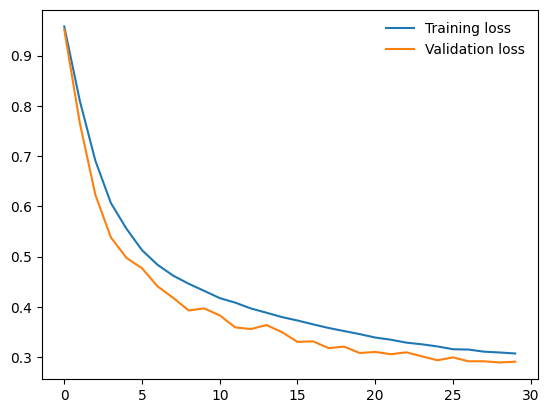

In [34]:
# plot the training and validation loss
plt.plot(track_loss, label='Training loss')
plt.plot(track_loss_val, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [35]:
model.load_state_dict(torch.load(configs['path_model']))

<All keys matched successfully>

In [36]:
data_path = path+'test/'
data_files = os.listdir(data_path)
data_files = [f.split('.')[0].split('_')[1] for f in data_files if f.startswith('images')]
N_items = len(data_files)

print("Number of items", N_items)

test_data = CustomDatasetNPY(data_path, data_files)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

Number of items 345


In [37]:
criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)

test = False

# track test loss
test_loss = 0.0
test_loss_baseline = 0.0
class_correct = list(0. for i in range(N_classes))
class_total = list(0. for i in range(N_classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()

max_samples = 1
cm_y_pred = []
cm_y_true = []
# iterate over test data
count = 0
for data, votes in tqdm(test_loader):
    if test and count >= max_samples:
      break
    count+=1

    data, votes = get_batch_transform(data, votes)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, votes = data.cuda(), votes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    if torch.isnan(output).sum() > 0:
        print("Nan in output")
    else:
      # calculate the batch loss
      loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
      # dummy is a tensor filled with 1/6 of shape [64,6]
      dummy = torch.ones(data.size(0), N_classes).to(device)
      dummy = dummy/N_classes
      loss_baseline = criterion(output.float(), F.log_softmax(dummy, dim=1))
      # update test loss
      test_loss += loss.item()#*data.size(0)
      test_loss_baseline += loss_baseline.item()#*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      target = torch.argmax(votes, axis=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(target.shape[0]):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

          cm_y_pred.append(pred[i].item())
          cm_y_true.append(target.data[i].item())

# average test loss
print()
test_loss = test_loss/len(test_loader.dataset)#/batch_size
print('Test Loss: {:.6f}\n'.format(test_loss))

test_loss_baseline = test_loss_baseline/len(test_loader.dataset)#/batch_size
print('Test Loss Baseline: {:.6f}\n'.format(test_loss_baseline))


100%|██████████| 345/345 [00:18<00:00, 18.26it/s]


Test Loss: nan

Test Loss Baseline: nan



In [38]:
for i in range(N_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Accuracy of seizure_vote: 67% (2848/4191)
Test Accuracy of lpd_vote: 12% (306/2412)
Test Accuracy of gpd_vote: 28% (1368/4813)
Test Accuracy of lrda_vote:  9% (300/3053)
Test Accuracy of grda_vote: 40% (1516/3773)
Test Accuracy of other_vote: 43% (1661/3809)

Test Accuracy (Overall): 36% (7999/22051)


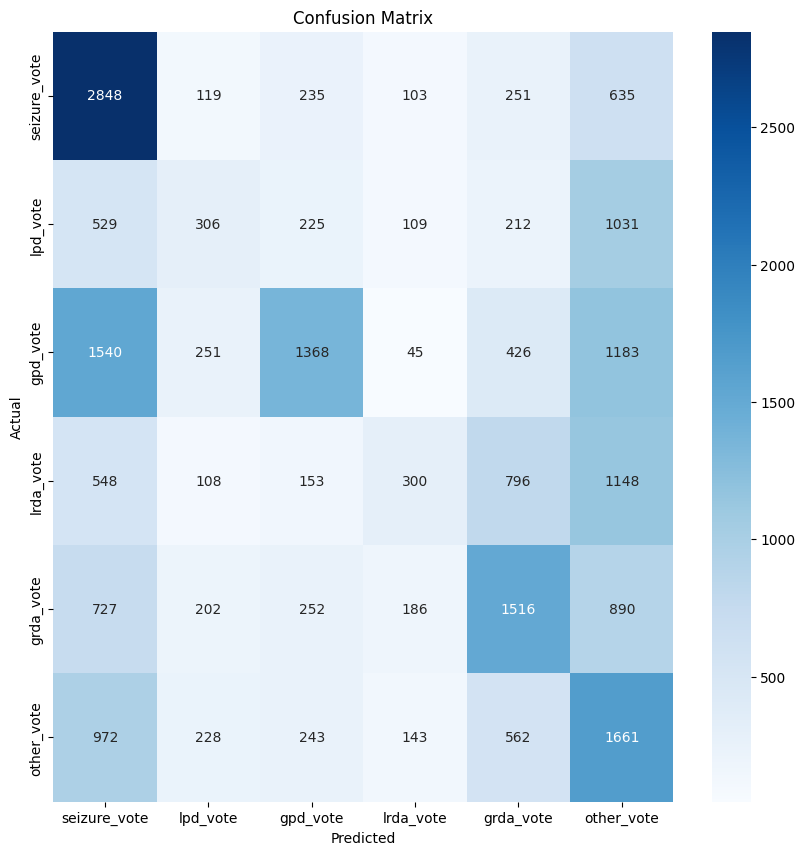

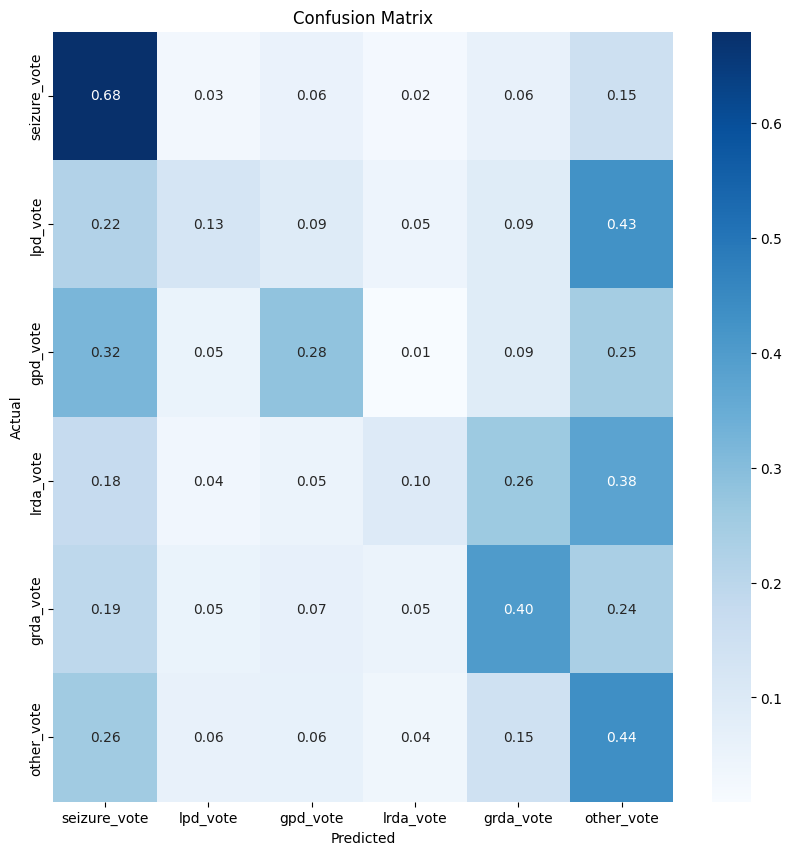

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(cm_y_true, cm_y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


confusion_matrix_p = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_p, annot=True, fmt=".2f", cmap='Blues')
plt.xticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(6) + 0.5, labels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
model_info['test_loss'] = test_loss
model_info['test_loss_baseline'] = test_loss_baseline
model_info['confusion_matrix'] = confusion_matrix.tolist()

In [41]:
model_info

{'configs': {'n_epochs': 30,
  'path_model': './model_CustomCNN_eeg_2.pt',
  'learning_rate': [0.0002,
   0.00063,
   0.00106,
   0.00149,
   0.00192,
   0.0019144017490824135,
   0.0018976726307031327,
   0.0018700087784795764,
   0.0018317345257857641,
   0.0017832986032400478,
   0.00172526887774889,
   0.00165832569478659,
   0.0015832539019666454,
   0.0015009336474210754,
   0.0014123300608682996,
   0.0013184819383496185,
   0.0012204895632954057,
   0.0011195018067078903,
   0.0010167026576990738,
   0.0009132973423009265,
   0.0008104981932921097,
   0.0007095104367045941,
   0.000611518061650382,
   0.0005176699391317006,
   0.00042906635257892496,
   0.0003467460980333547,
   0.0002716743052134104,
   0.00020473112225111043,
   0.00014670139675995223,
   9.826547421423595e-05],
  'label_smoothing': 0.01},
 'track_loss': [0.9580633332209332,
  0.8102339267730713,
  0.6909082944746371,
  0.6064577691103696,
  0.5554496324601977,
  0.5126784919220724,
  0.4836017321902538,
  0.

In [42]:
# save model_info as json
model_info_path = f"./model_info_{model_name}_{index}.json"

import json
with open(model_info_path, 'w') as f:
    json.dump(model_info, f)